# Welcome and have fun learning multiclass classification with plug and play Neural Network

#### Metric: **Accuracy**. Softvoting and weighted average is the objective to score towards target class.

Objective of this notebook used to be a ~simple~ and robust neural network multiclass classifier for future use.

<blockquote style="margin-right:auto; margin-left:auto; padding: 1em; margin:24px;">
    <strong>Fork This Notebook!</strong><br>
Create your own editable copy of this notebook by clicking on the <strong>Copy and Edit</strong> button in the top right corner.
</blockquote>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
from scipy import stats
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, RobustScaler, PowerTransformer, OneHotEncoder
le = LabelEncoder()
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.model_selection import KFold, StratifiedKFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

from datetime import datetime
from packaging import version

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."
import tensorboard
tensorboard.__version__
# Clear any logs from previous runs
!rm -rf ./logs/ 

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import gc
import os
import math

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

TensorFlow version:  2.6.2


## Fine tuning
Fine tune the system using the hyperparameters and configs below:
* FOLD - 5, 10, 15, 20.
* SAMPLE - Set it to True for full sample run. Max sample per class.
* BEST_OR_FOLD - True: use Best model, False: use KFOLD softvote
* TPU - Only works on save version.
* selu love lecun_normal

In [2]:
# -----------------------------------------------------------------
# Some parameters to config 
PRODUCTION = True # True: For submission run. False: Fast trial run

# Hyperparameters
FOLDS = 20 if PRODUCTION else 5   # Only 5 or 10.
EPOCHS = 88        # Does not matter with Early stopping. Deep network should not take too much epochs to learn
BATCH_SIZE = 2048   # large enough to fit RAM. If unstable, tuned downward. 4096 2048
ACTIVATION = 'swish' # swish mish relu selu ;swish overfit more cause of narrow global minimun
KERNEL_INIT = "glorot_normal" # Minimal impact, but give your init the right foot forward glorot_uniform lecun_normal
LEARNING_RATE = 0.000965713 # Not used. Optimal lr is about half the maximum lr 
LR_FACTOR = 0.5   # LEARNING_RATE * LR_FACTOR = New Learning rate on ReduceLROnPlateau. lower down when the LR oscillate
MIN_DELTA = 0.0000001 # Default 0.0001 0.0000001
RLRP_PATIENCE = 5 # Learning Rate reduction on ReduceLROnPlateau
ES_PATIENCE = 21  # Early stopping
DROPOUT = 0.05     # Act like L1 L2 regulator. lower your learning rate in order to overcome the "boost" that the dropout probability gives to the learning rate.
HIDDEN_LAYERS = [256, 128, 64]

OPTIMIZER = 'adam' # adam adamax nadam
LOSS ='sparse_categorical_crossentropy' # sparse_categorical_crossentropy does not require onehot encoding on labels. categorical_crossentropy
METRICS ='sparse_categorical_accuracy'  # acc accuracy categorical_accuracy sparse_categorical_accuracy
ACC_VAL_METRICS = 'val_sparse_categorical_accuracy' # 'val_acc' val_accuracy val_sparse_categorical_accuracy
ACC_METRICS = 'sparse_categorical_accuracy' # acc accuracy 'sparse_categorical_accuracy'

# The dataset is too huge for trial. Sampling it for speed run!
SAMPLE = 20139 if PRODUCTION else 500   # True for FULL run. Max Sample size per category. For quick test: y counts [20139, 20063, 19947, 19958, 19937, 19847, 20030, 19929, 20074, 20076]  # 200000 total rows
VALIDATION_SPLIT = 0.15 # Only used to min dataset for quick test
MAX_TRIAL = 3           # speed trial any% Not used here
MI_THRESHOLD = 0.001    # Mutual Information threshold value to drop.

RANDOM_STATE = 42
VERBOSE = 0

# Admin
ID = "row_id"            # Id id x X index
INPUT = "../input/tabular-playground-series-feb-2022"
TPU = False           # True: use TPU.
BEST_OR_FOLD = False # True: use Best model, False: use KFOLD softvote
FEATURE_ENGINEERING = True
PSEUDO_LABEL = False
BLEND = False

assert BATCH_SIZE % 2 == 0, \
    "BATCH_SIZE must be even number."

In [3]:
# for col in df.select_dtypes('int').columns:
#     df[col] = pd.to_numeric(df[col], downcast = 'integer')

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
 
    return df

In [4]:
from pathlib import Path


def load_data():
    # Read data
    data_dir = Path(INPUT)
    df_train = pd.read_csv(data_dir / "train.csv", index_col=ID)
    df_test = pd.read_csv(data_dir / "test.csv", index_col=ID)
    column_y = df_train.columns.difference(
        df_test.columns)[0]  # column_y target_col label_col
    return df_train, df_test, column_y

## Data Preprocessing ##

Before we can do any feature engineering, we need to *preprocess* the data to get it in a form suitable for analysis. We'll need to:
- **Load** the data from CSV files
- **Clean** the data to fix any errors or inconsistencies
- **Encode** the statistical data type (numeric, categorical)
- **Impute** any missing values

We'll wrap all these steps up in a function, which will make easy for you to get a fresh dataframe whenever you need. After reading the CSV file, we'll apply three preprocessing steps, `clean`, `encode`, and `impute`, and then create the data splits: one (`df_train`) for training the model, and one (`df_test`) for making the predictions that you'll submit to the competition for scoring on the leaderboard.

In [5]:
%%time
train_data, test_data, column_y = load_data()

CPU times: user 20.9 s, sys: 1.25 s, total: 22.2 s
Wall time: 36.3 s


In [6]:
np.unique(train_data[column_y], return_counts=True)

(array(['Bacteroides_fragilis', 'Campylobacter_jejuni',
        'Enterococcus_hirae', 'Escherichia_coli', 'Escherichia_fergusonii',
        'Klebsiella_pneumoniae', 'Salmonella_enterica',
        'Staphylococcus_aureus', 'Streptococcus_pneumoniae',
        'Streptococcus_pyogenes'], dtype=object),
 array([20139, 20063, 19947, 19958, 19937, 19847, 20030, 19929, 20074,
        20076]))

In [7]:
X = train_data.drop(columns=column_y)
y = train_data[[column_y]]

X_test = test_data.loc[:,X.columns]

gc.collect()

64

# Undersampling
For experiment measurements

In [8]:
def sampling_size_params(labels, sampling_max_size = SAMPLE):
    ''' Return sampling parameters {labels: sample_size}'''
    sampling_key, sampling_count = np.unique(labels, return_counts=True)
    sampling_count[sampling_count > sampling_max_size] = sampling_max_size
    zip_iterator = zip(sampling_key, sampling_count)
    return dict(zip_iterator)

# not minority
sampling_params = sampling_size_params(y, SAMPLE)
undersample = RandomUnderSampler(
    sampling_strategy=sampling_params, random_state=RANDOM_STATE)

X, y = undersample.fit_resample(X, y)

In [9]:
# Prepare for multiclass classification tf.keras.utils.to_categorical(le.fit_transform(y[column_y])) categorical_crossentropy
y_cat = le.fit_transform(y[column_y]) # y to categorical
# train_data[column_y] = y_cat

In [10]:
transform_cols = X.columns # Numeric features

In [11]:
# Check NA
missing_val = X.isnull().sum()
print(missing_val[missing_val > 0])

Series([], dtype: int64)


In [12]:
from sklearn.feature_selection import mutual_info_regression
def make_mi_scores(X, y, random_state=0):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=random_state)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.rcParams["figure.figsize"] = (15,12)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
def drop_uninformative(df, mi_scores, threshold = 0.001):
    return df.loc[:, mi_scores > threshold]

In [13]:
def plot_features(features, df):
    for feature in features:
        plt.rcParams["figure.figsize"] = (15,9)
        for ctype in list(df[column_y].unique()):
            values = df.loc[df[column_y] == ctype][feature].values
            sns.scatterplot(x=values, y=np.arange(values.size), label=f"{column_y} {ctype}", alpha=0.3, palette="deep")
        plt.title(feature)
        plt.legend()
        plt.show()

features_cols = ['A0T0G6C4',
                 'A8T0G1C1',
                ]

# plot_features(features=features_cols,df=small_sampling)

In [14]:
np.unique(y, return_counts=True)

(array(['Bacteroides_fragilis', 'Campylobacter_jejuni',
        'Enterococcus_hirae', 'Escherichia_coli', 'Escherichia_fergusonii',
        'Klebsiella_pneumoniae', 'Salmonella_enterica',
        'Staphylococcus_aureus', 'Streptococcus_pneumoniae',
        'Streptococcus_pyogenes'], dtype=object),
 array([20139, 20063, 19947, 19958, 19937, 19847, 20030, 19929, 20074,
        20076]))

In [15]:
CSV_HEADER = list(train_data.columns[:])

TARGET_FEATURE_NAME = column_y

TARGET_FEATURE_LABELS = np.unique(y_cat)

NUMERIC_FEATURE_NAMES = list(X.columns[:])

CATEGORICAL_FEATURES_WITH_VOCABULARY = {}

CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())

FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES

COLUMN_DEFAULTS = [
    [0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]

NUM_CLASSES = len(TARGET_FEATURE_LABELS)

INPUT_SHAPE = X.shape[-1]
OUTPUT_SHAPE = le.classes_.shape[-1]

In [16]:
print(INPUT_SHAPE)
print(OUTPUT_SHAPE)

286
10


In [17]:
# del mi_scores
# del small_sampling
del train_data
gc.collect()

105

# Scaler transformer
By using RobustScaler(), we can remove the outliers
![](https://github.com/furyhawk/kaggle_practice/blob/main/images/Scalers.png?raw=true)

In [18]:
transformer_num_cols = make_pipeline(
    RobustScaler(),
#     StandardScaler(),
#     MinMaxScaler(feature_range=(0, 1))
)

preprocessor = make_column_transformer(
    (transformer_num_cols, transform_cols)
)

TODO: within folds

In [19]:
X_train_transformed = preprocessor.fit_transform(X)
X_test_transformed = preprocessor.transform(X_test)

# Train Model and Create Submissions #

Once you're satisfied with everything, it's time to create your final predictions! This cell will:
- use the best trained model to make predictions from the test set
- save the predictions to a CSV file

$Softmax: \sigma(z_i) = \frac{e^{z_{i}}}{\sum_{j=1}^K e^{z_{j}}} \ \ \ for\ i=1,2,\dots,K$

K - number of classes

$z_i$ - is a vector containing the scores of each class for the instance z.

$\sigma(z_i)$ - is the estimated probability that the instance z belongs to class K, given the scores of each class for that instance.

$Relu(z) = max(0, z)$

Binary Cross Entropy: $-{(y\log(p) + (1 - y)\log(1 - p))}$

For multiclass classification, we calculate a separate loss for each class label per observation and sum the result.

$-\sum_{c=1}^My_{o,c}\log(p_{o,c})$


    M - number of classes

    log - the natural log

    y - binary indicator (0 or 1) if class label c is the correct classification for observation o

    p - predicted probability observation o is of class c



## Basic neural network blocks

In [20]:
modelCheckpoint = None

if TPU:
    save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
    modelCheckpoint = ModelCheckpoint(  'best_model', options = save_locally,
                                        monitor = ACC_VAL_METRICS,
                                        mode = 'max',
                                        save_best_only = True,
                                        verbose = VERBOSE,
                                        )
else:
    modelCheckpoint = ModelCheckpoint(
                                        'best_model',
                                        monitor = ACC_VAL_METRICS,
                                        mode = 'max',
                                        save_best_only = True,
                                        verbose = VERBOSE,
                                        )

early_stopping = EarlyStopping(
        patience = ES_PATIENCE,
        min_delta = MIN_DELTA,
        monitor = ACC_VAL_METRICS,
        mode = 'max',
        restore_best_weights = True,       
        baseline = None,
        verbose = VERBOSE,
    )
plateau = ReduceLROnPlateau(
        patience = RLRP_PATIENCE,
        factor = LR_FACTOR,
        min_lr = 1e-7,
        monitor = 'val_loss', 
        mode = 'min',
        verbose = VERBOSE,
    )

def get_MLPmodel(**kwargs):
# -----------------------------------------------------------------
# Model , kernel_initializer="lecun_normal"
    model = keras.Sequential([
#     layers.BatchNormalization(input_shape = [X.shape[-1]], name = 'input'),
    layers.Dense(units = 300, input_shape = [INPUT_SHAPE], name = 'input', kernel_initializer = KERNEL_INIT, activation = ACTIVATION),
#     layers.Dropout(rate = DROPOUT),
    layers.BatchNormalization(),
    layers.Dense(units = 200, kernel_initializer = KERNEL_INIT, activation = ACTIVATION),
#     layers.Dropout(rate = DROPOUT),
    layers.BatchNormalization(),
    layers.Dense(units = 100, kernel_initializer = KERNEL_INIT, activation = ACTIVATION),
#     layers.Dropout(rate = DROPOUT),
    layers.BatchNormalization(),
    layers.Dense(units = 50, kernel_initializer = KERNEL_INIT, activation = ACTIVATION),
#     layers.Dropout(rate = DROPOUT),
    layers.BatchNormalization(),
    layers.Dense(units = OUTPUT_SHAPE, activation = 'softmax', name='output'), #y_cat.shape[-1]
    ])

    return model

In [21]:
class MCDropout(keras.layers.AlphaDropout):
    '''Boost the performance of any trained dropout model without having to retrain it or even modify it at all.
        Provide a much better measure of the models uncertainty'''
    def call(self, inputs):
        return super().call(inputs, training=True)

class Standardization(layers.Layer):
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, axis = 0, keepdims = True)
        self.stds_ = np.std(data_sample, axis = 0, keepdims = True)
    def call(self, inputs):
        return (inputs - self.means_) / (self.stds_ + keras.backend.epsilon())
    
# create custom dense-block
class DenseBlock(layers.Layer):
    def __init__(self, units, activation = ACTIVATION, dropout_rate = 0, l2 = 0, **kwargs):
        super(DenseBlock, self).__init__(**kwargs)
        self.dense = layers.Dense(
            units = units, 
#             activation = activation,
            kernel_initializer = KERNEL_INIT, 
#             kernel_regularizer=keras.regularizers.l2(l2)
        )
        self.batchn = layers.BatchNormalization()
        self.activation = layers.Activation(activation)
        if dropout_rate > 0:
            self.dropout = layers.Dropout(rate = dropout_rate) #MCDropout layers.Dropout
        else:
            self.dropout = None
    
    def call(self, inputs):
        x = self.dense(inputs)
        x = self.activation(x)
        x = self.batchn(x)
        
        if self.dropout is not None:
            x = self.dropout(x)
            
        return x

# create fully-connected NN
class MLP(keras.Model):
    def __init__(self, hidden_layers = HIDDEN_LAYERS, activation = ACTIVATION, dropout_rate = DROPOUT, l2 = 0, **kwargs):
        super(MLP, self).__init__(**kwargs)

        self.hidden_layers = [DenseBlock(units = units,
                                         activation = activation,
                                         dropout_rate = dropout_rate,
                                         l2 = l2
                                        )
                              for units in hidden_layers
                             ]
        self.softmax = layers.Dense(units = OUTPUT_SHAPE, activation = 'softmax', name='output')
        
    def call(self, inputs):
        x = inputs
        for dense_layer in self.hidden_layers:
            x = dense_layer(x)
        x = self.softmax(x)
        return x

### DCNv2 Parrallel Deep & Cross Network
CrossNet from https://www.kaggle.com/mlanhenke/tps-12-deep-cross-nn-keras

In [22]:
# create dense & cross model
class CrossNet(keras.Model):
    def __init__(self, hidden_layers = HIDDEN_LAYERS, activation = ACTIVATION, dropout_rate = DROPOUT, l2 = 0, **kwargs):
        super(CrossNet, self).__init__(**kwargs)

        for i, units in enumerate(hidden_layers, start=1):
            if i == 1: # Dropout before last layer only len(hidden_layers)
                self.dense_layers = [DenseBlock(units = units, activation = activation, dropout_rate = dropout_rate, l2 = l2)]
            else:
                self.dense_layers.append(DenseBlock(units = units, activation = activation, dropout_rate = 0, l2 = l2))
        
        self.dense = layers.Dense(units = INPUT_SHAPE)
        self.concat = layers.Concatenate()
        self.batchn = layers.BatchNormalization()
        self.softmax = layers.Dense(units = OUTPUT_SHAPE, activation = 'softmax', name='output')
        
    def call(self, inputs):
        
        dense, cross = inputs, inputs
        
        for dense_layer in self.dense_layers:
            # Deep net TODO only dropout at last layer
            dense = dense_layer(dense)
            # Parrallel Cross net
            cross_current = self.dense(cross)
            cross = inputs * cross_current + cross
            
        cross = self.batchn(cross)
        
        merged = self.concat([dense, cross])
        return self.softmax(merged)

In [23]:
def wide_deep_model(**kwargs):
    il = layers.Input(shape=(INPUT_SHAPE), name="input")
    x1 = layers.Dense(units=100, activation=ACTIVATION)(il)
    x = layers.Dropout(DROPOUT)(x1)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(units=200, activation=ACTIVATION)(x)
    x = layers.Dropout(DROPOUT)(x)
    x = layers.BatchNormalization()(x) #AlphaDropout
    x = layers.Dense(units=100, activation=ACTIVATION)(layers.Concatenate()([x, x1]))
    x = layers.Dropout(DROPOUT)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(units=50, activation=ACTIVATION)(x)
    x = layers.BatchNormalization()(x)
    output = layers.Dense(units=NUM_CLASSES, activation="softmax", name="output")(x)

    model = tf.keras.Model([il], output)
    return model

In [24]:
def create_deep_and_cross_model(hidden_units = HIDDEN_LAYERS, dropout_rate = DROPOUT):
    '''DCNv2 Model'''
    inputs = layers.Input(len(X.columns)) #create_model_inputs()
    x0 = encode_inputs(inputs, use_embedding=True)

    cross = x0
    for _ in hidden_units:
        units = cross.shape[-1]
        x = layers.Dense(units)(cross)
        cross = x0 * x + cross
    cross = layers.BatchNormalization()(cross)

    deep = x0
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([cross, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

## Classification with Gated Residual and Variable Selection Networks

From [TPS-12] G-Res & Variable Selection NN (Keras) https://www.kaggle.com/mlanhenke/tps-12-g-res-variable-selection-nn-keras

In [25]:
class GatedLinearUnit(layers.Layer):
    def __init__(self, units, **kwargs):
        super(GatedLinearUnit, self).__init__(**kwargs)
        self.linear = layers.Dense(units)
        self.sigmoid = layers.Dense(units, activation="sigmoid")

    def call(self, inputs):
        return self.linear(inputs) * self.sigmoid(inputs)

class GatedResidualNetwork(layers.Layer):
    def __init__(self, units, dropout_rate, **kwargs):
        super(GatedResidualNetwork, self).__init__(**kwargs)
        self.units = units
        self.elu_dense = layers.Dense(units, activation="elu")
        self.linear_dense = layers.Dense(units)
        self.dropout = layers.Dropout(dropout_rate)
        self.gated_linear_unit = GatedLinearUnit(units)
        self.layer_norm = layers.LayerNormalization()
        self.project = layers.Dense(units)

    def call(self, inputs):
        x = self.elu_dense(inputs)
        x = self.linear_dense(x)
        x = self.dropout(x)
        if inputs.shape[-1] != self.units:
            inputs = self.project(inputs)
        x = inputs + self.gated_linear_unit(x)
        x = self.layer_norm(x)
        return x

class VariableSelection(layers.Layer):
    def __init__(self, num_features, units, dropout_rate, **kwargs):
        super(VariableSelection, self).__init__(**kwargs)
        self.grns = list()
        for idx in range(num_features):
            grn = GatedResidualNetwork(units, dropout_rate)
            self.grns.append(grn)
        self.grn_concat = GatedResidualNetwork(units, dropout_rate)
        self.softmax = layers.Dense(units=num_features, activation="softmax")

    def call(self, inputs):
        v = layers.concatenate(inputs)
        v = self.grn_concat(v)
        v = tf.expand_dims(self.softmax(v), axis=-1)

        x = []
        for idx, input in enumerate(inputs):
            x.append(self.grns[idx](input))
        x = tf.stack(x, axis=1)

        outputs = tf.squeeze(tf.matmul(v, x, transpose_a=True), axis=1)
        return outputs
def encode_vsn_inputs(inputs, encoding_size):
    encoded_features = []
    for col in range(inputs.shape[1]):
        encoded_feature = tf.expand_dims(inputs[:, col], -1)
        encoded_feature = layers.Dense(units=encoding_size)(encoded_feature)
        encoded_features.append(encoded_feature)
    return encoded_features

def create_grn_and_vsn_model(encoding_size, dropout_rate=DROPOUT):
    inputs = layers.Input(len(X.columns))
    feature_list = encode_vsn_inputs(inputs, encoding_size)
    num_features = len(feature_list)

    features = VariableSelection(num_features, encoding_size, dropout_rate)(
        feature_list
    )

    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(features)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [26]:
kf = StratifiedKFold(
        n_splits=FOLDS, random_state=RANDOM_STATE, shuffle=True)

In [27]:
%%time

# Define the Keras TensorBoard callback.
#logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

ENCODING_SIZE = 4 if PRODUCTION else 4 # Encoding size for create_grn_and_vsn_model
strategy = None
if TPU:
    try:  # detect TPUs
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()  # TPU detection
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:  # detect GPUs
        # default strategy that works on CPU and single GPU
        strategy = tf.distribute.get_strategy()
        print("Number of accelerators: ", strategy.num_replicas_in_sync)
        # this is 8 on TPU v3-8, it is 1 on CPU and GPU
        BATCH_SIZE = 16 * strategy.num_replicas_in_sync

# if TPU:        # instantiating the model in the strategy scope creates the model on the TPU
# resets
preds_valid_f = {}
preds_test = np.zeros((1, 1))  # [] init Soft voting
total_acc = []
f_scores = []
models = []

# best_model = load_model('../input/dcnv2-softmaxclassification/best_model')
# preds_test = preds_test + best_model.predict(X_test_transformed, batch_size = BATCH_SIZE)

for fold, (train_index, valid_index) in enumerate(kf.split(X=X, y=y[TARGET_FEATURE_NAME])):

    X_train, X_valid = X_train_transformed[train_index], X_train_transformed[valid_index]
    y_train, y_valid = y_cat[train_index], y_cat[valid_index]

    #   --------------------------------------------------------
    # Preprocessing
    index_valid = valid_index.tolist()

    #    --------------------------------------------------------
    #
    #  ----------------------------------------------------------
    # Model# instantiating the model in the strategy scope creates the model on the TPU
    if TPU:
        with strategy.scope():
            model = CrossNet(
                hidden_layers=HIDDEN_LAYERS,
                activation=ACTIVATION,
                dropout_rate=DROPOUT
            )
            model.compile(
                optimizer=OPTIMIZER, loss=LOSS, metrics=[METRICS],
            )

    else:  # CPU/GPU model = create_grn_and_vsn_model(encoding_size=ENCODING_SIZE)  wide_deep_model get_MLPmodel
        model = CrossNet(
                hidden_layers=HIDDEN_LAYERS,
                activation=ACTIVATION,
                dropout_rate=DROPOUT
                )
        model.compile(
            optimizer=OPTIMIZER, loss=LOSS, metrics=[METRICS],
            )

    history = model.fit(X_train, y_train,
                        validation_data=(X_valid, y_valid),
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        callbacks=[early_stopping, plateau, modelCheckpoint,  # tensorboard_callback
                                   ],
                        shuffle=True,
                        verbose=VERBOSE,
                        )

    #  ----------------------------------------------------------
    #  oof
    preds_valid = model.predict(X_valid, batch_size=BATCH_SIZE)

    #  ----------------------------------------------------------
    #********  test dataset predictions for submission *********#
    if not BEST_OR_FOLD:
        preds_test = preds_test + \
            model.predict(X_test_transformed, batch_size=BATCH_SIZE)

    #  ----------------------------------------------------------
    #  Saving scores to plot the end
    scores = pd.DataFrame(history.history)
    scores['folds'] = fold
    if fold == 0:
        f_scores = scores
        model.summary()
#         keras.utils.plot_model(model, show_shapes=True, rankdir="LR")
    else:
        f_scores = pd.concat([f_scores, scores], axis=0)

    #  ----------------------------------------------------------
    #  concatenating valid preds
    preds_valid_f.update(
        dict(zip(index_valid, le.inverse_transform(np.argmax(preds_valid, axis=1)))))
    # Getting score for a fold model
    fold_acc = accuracy_score(y.iloc[valid_index].target, le.inverse_transform(
        np.argmax(preds_valid, axis=1)))
    print(
        f"Fold {fold} accuracy_score: {fold_acc} Train: {X_train.shape} Valid: {X_valid.shape}")
    # Total acc
    total_acc.append(fold_acc)

    del model
    gc.collect()
    K.clear_session()

print(f"mean accuracy_score: {np.mean(total_acc)}, std: {np.std(total_acc)}")

2022-02-02 14:41:17.117595: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-02 14:41:17.216080: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-02 14:41:17.216853: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-02 14:41:17.218072: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "cross_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_block (DenseBlock)     multiple                  74496     
_________________________________________________________________
dense_block_1 (DenseBlock)   multiple                  33408     
_________________________________________________________________
dense_block_2 (DenseBlock)   multiple                  8512      
_________________________________________________________________
dense_3 (Dense)              multiple                  82082     
_________________________________________________________________
concatenate (Concatenate)    multiple                  0         
_________________________________________________________________
batch_normalization_3 (Batch multiple                  1144      
_________________________________________________________________
output (Dense)               multiple                  35

In [28]:
# Load best_model
if BEST_OR_FOLD:
    if not TPU:
        # load the saved model
        best_model = load_model('best_model')
    else: # TPU
        with strategy.scope():
            load_locally = tf.saved_model.LoadOptions(experimental_io_device = '/job:localhost')
            best_model = tf.keras.models.load_model('best_model', options = load_locally) # loading in Tensorflow's "SavedModel" format
    # Using best model to predict
    # X_test = preprocessor.transform(X_test) Not using best loop fit TODO
    preds_test = preds_test + best_model.predict(X_test_transformed, batch_size = BATCH_SIZE)

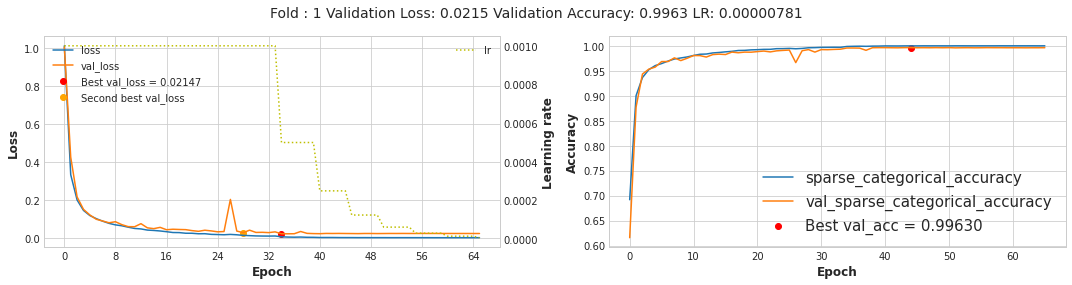

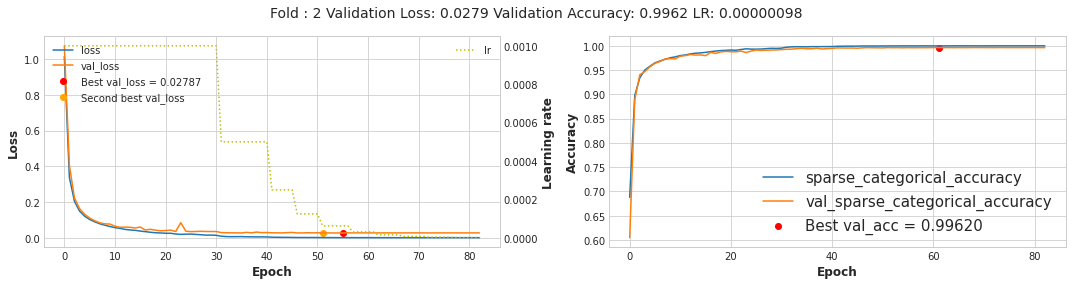

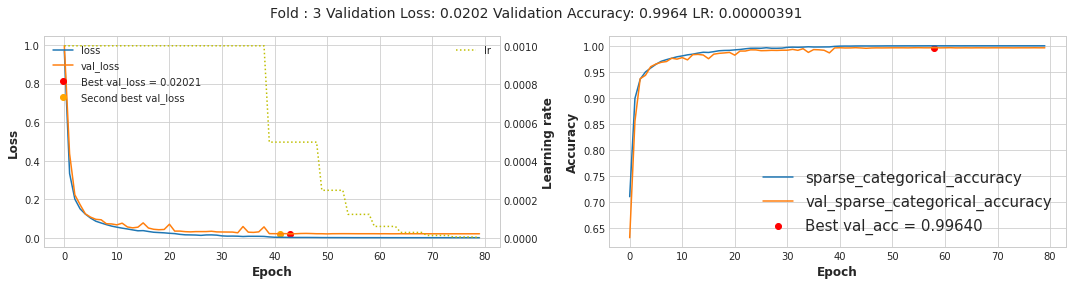

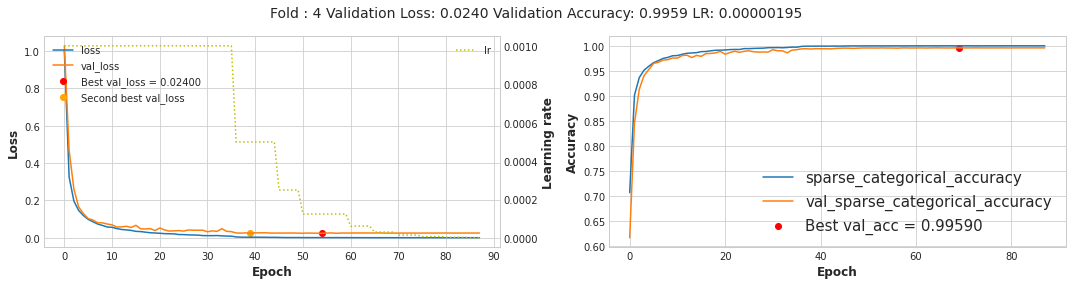

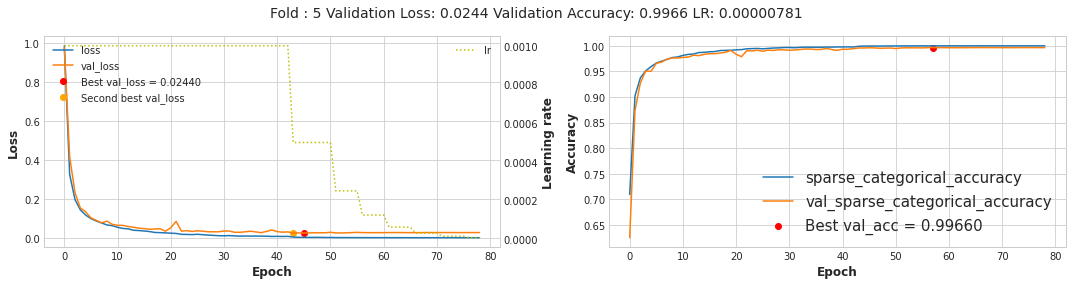

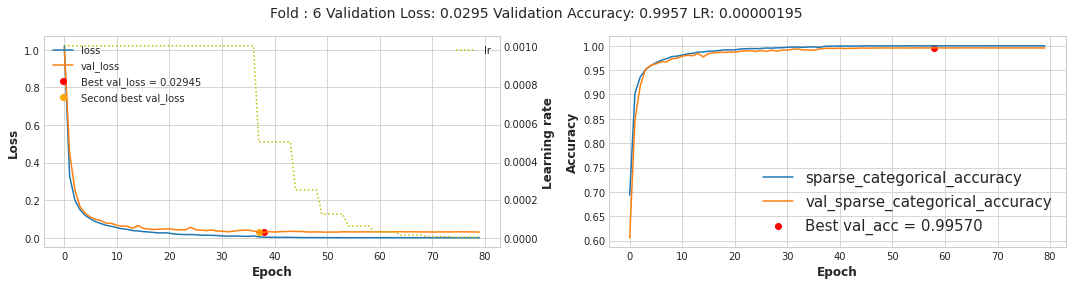

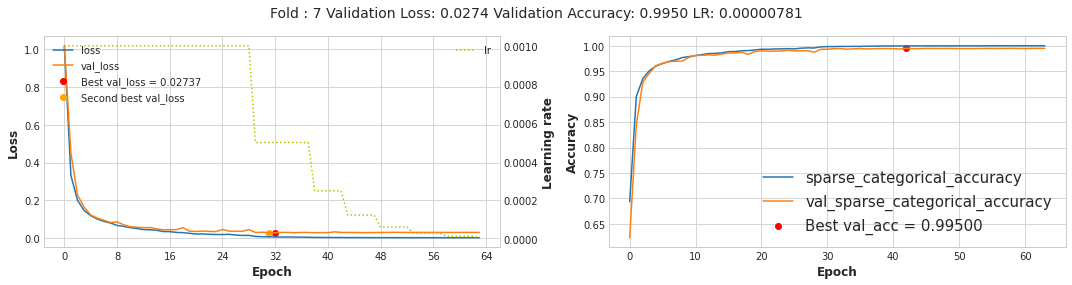

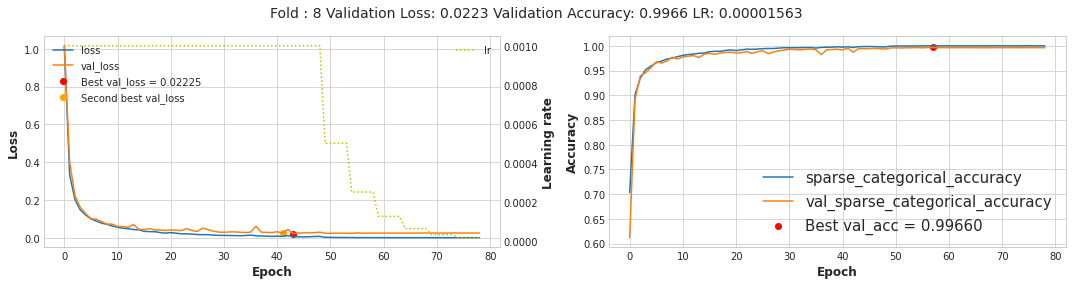

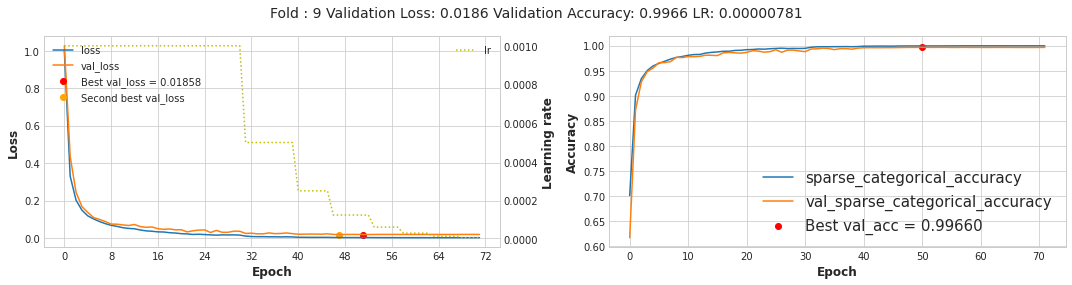

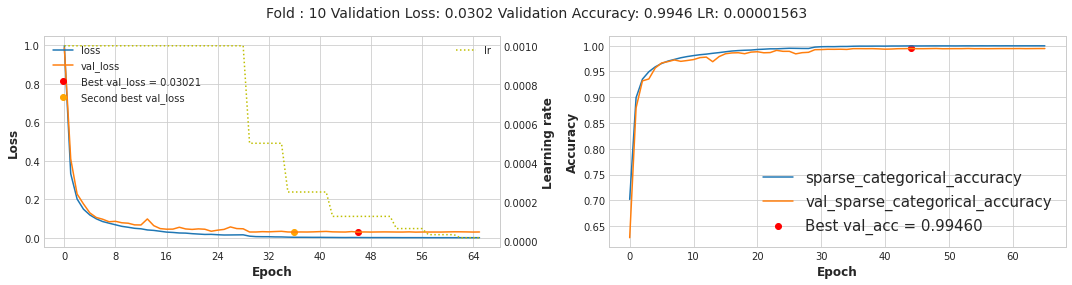

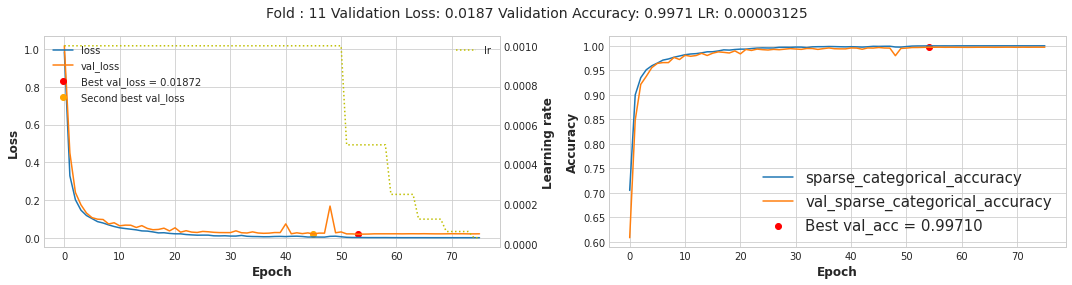

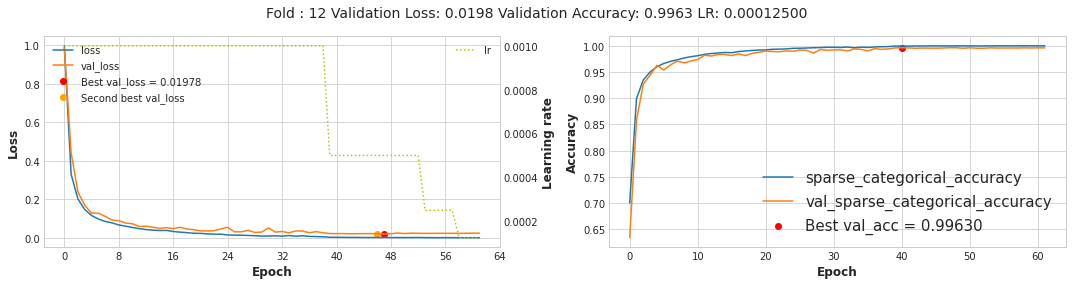

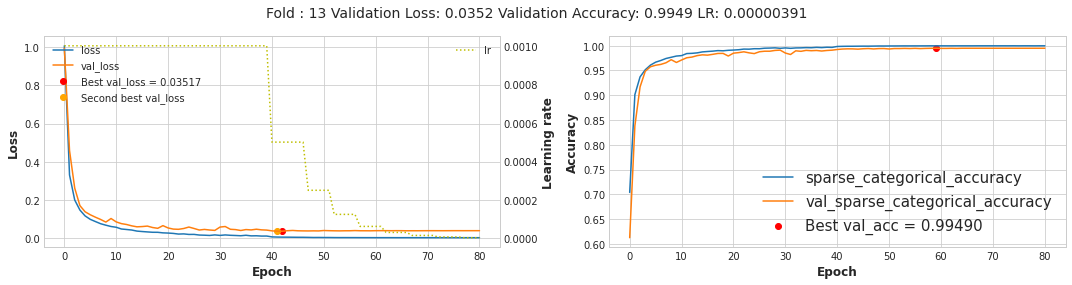

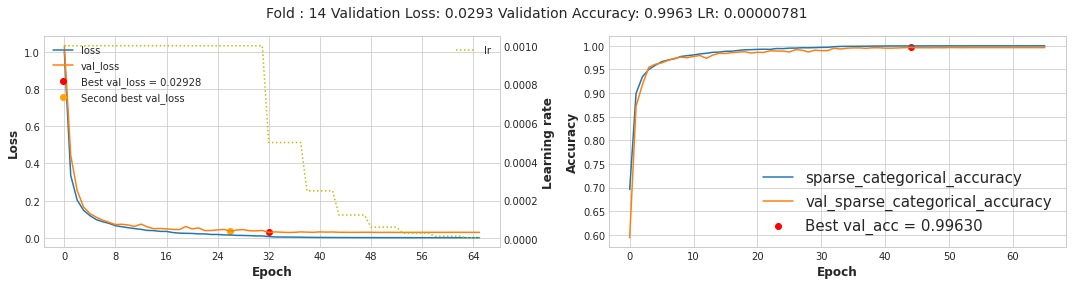

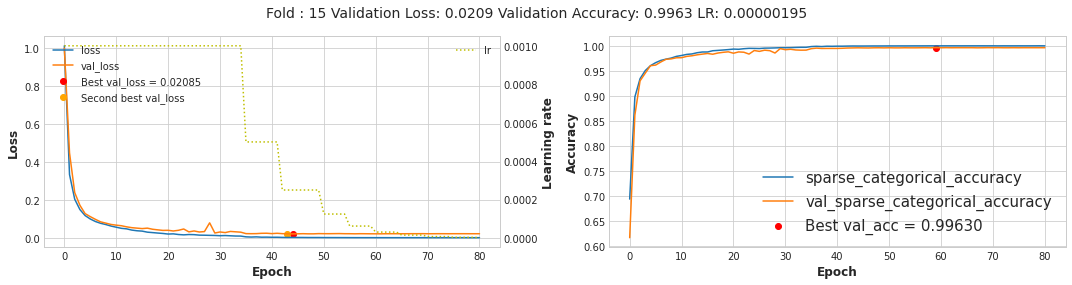

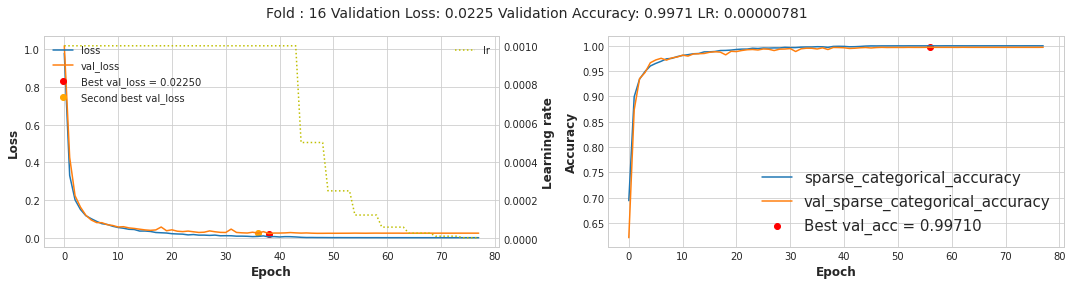

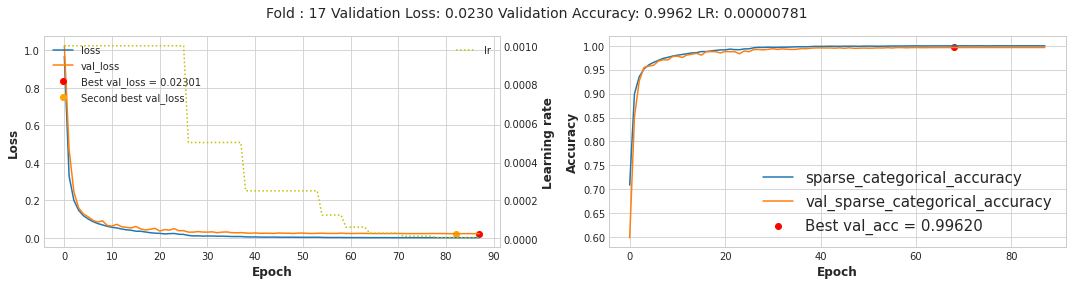

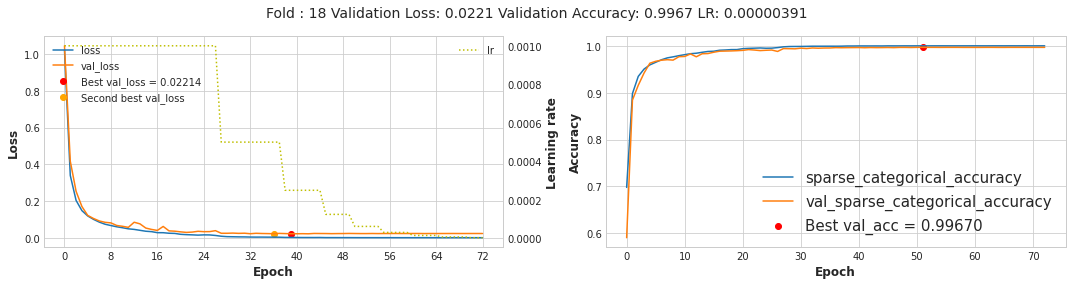

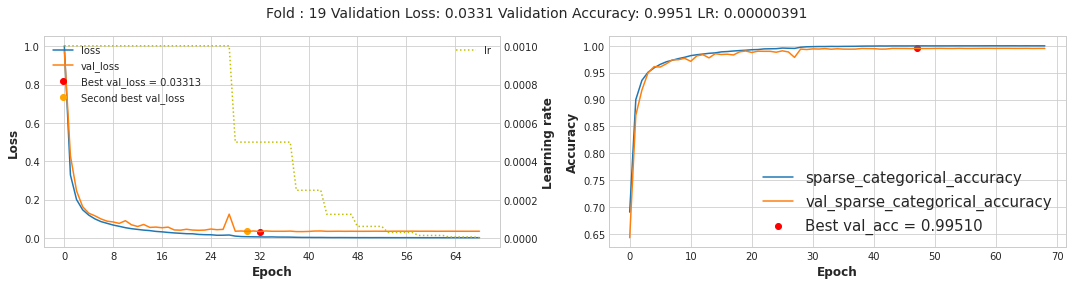

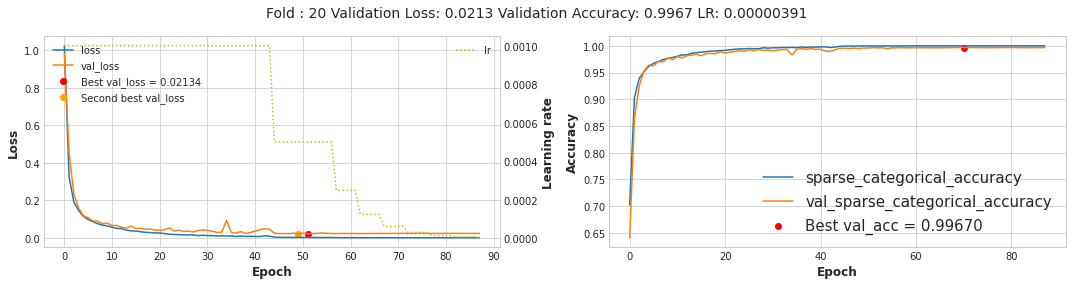

In [29]:
def plot_acc(f_scores):
    for fold in range(f_scores['folds'].nunique()):
        history_f = f_scores[f_scores['folds'] == fold]

        best_epoch = np.argmin(np.array(history_f['val_loss']))
        best_val_loss = history_f['val_loss'][best_epoch]

        fig, ax1 = plt.subplots(1, 2, tight_layout=True, figsize=(15,4))

        fig.suptitle('Fold : '+ str(fold+1) +
                     " Validation Loss: {:0.4f}".format(history_f['val_loss'].min()) +
                     " Validation Accuracy: {:0.4f}".format(history_f[ACC_VAL_METRICS].max()) +
                     " LR: {:0.8f}".format(history_f['lr'].min())
                     , fontsize=14)

        plt.subplot(1,2,1)
        plt.plot(history_f.loc[:, ['loss', 'val_loss']], label= ['loss', 'val_loss'])
                
        from_epoch = 0
        if best_epoch >= from_epoch:
            plt.scatter([best_epoch], [best_val_loss], c = 'r', label = f'Best val_loss = {best_val_loss:.5f}')
        if best_epoch > 0:
            almost_epoch = np.argmin(np.array(history_f['val_loss'])[:best_epoch])
            almost_val_loss = history_f['val_loss'][almost_epoch]
            if almost_epoch >= from_epoch:
                plt.scatter([almost_epoch], [almost_val_loss], c='orange', label = 'Second best val_loss')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc='upper left')   
        
        ax2 = plt.gca().twinx()
        ax2.plot(history_f.loc[:, ['lr']], 'y:', label='lr' ) # default color is same as first ax
        ax2.set_ylabel('Learning rate')
        ax2.legend(loc = 'upper right')
        ax2.grid()

        best_epoch = np.argmax(np.array(history_f[ACC_VAL_METRICS]))
        best_val_acc = history_f[ACC_VAL_METRICS][best_epoch]
        
        plt.subplot(1,2,2)
        plt.plot(history_f.loc[:, [ACC_METRICS, ACC_VAL_METRICS]],label= [ACC_METRICS, ACC_VAL_METRICS])
        if best_epoch >= from_epoch:
            plt.scatter([best_epoch], [best_val_acc], c = 'r', label = f'Best val_acc = {best_val_acc:.5f}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc = 'lower left')
        plt.legend(fontsize = 15)
        plt.grid(visible = True, linestyle = '-')

plot_acc(f_scores)

But instead of just looking at the mean accuracy across the 10 cross-validation folds, let's plot all 10 scores for each model, along with a box plot highlighting the lower and upper quartiles, and "whiskers" showing the extent of the scores. Note that the `boxplot()` function detects outliers (called "fliers") and does not include them within the whiskers. Specifically, if the lower quartile is $Q_1$ and the upper quartile is $Q_3$, then the interquartile range $IQR = Q_3 - Q_1$ (this is the box's height), and any score lower than $Q_1 - 1.5 \times IQR$ is a flier, and so is any score greater than $Q3 + 1.5 \times IQR$.

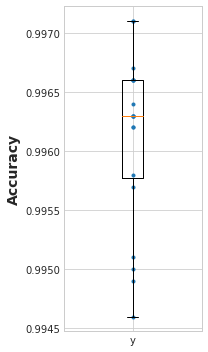

In [30]:
plt.figure(figsize = (3, 5))
plt.plot([1]*FOLDS, total_acc, ".")
plt.boxplot([total_acc], labels = ("y"))
plt.ylabel("Accuracy", fontsize = 14)
plt.show()

In [31]:
def plot_cm(cm):
    metrics = {
        'accuracy': cm / cm.sum(),
        'recall' : cm / cm.sum(axis =1 ),
        'precision': cm / cm.sum(axis = 0)
    }
    
    fig, ax = plt.subplots(1,3, tight_layout = True, figsize = (25,8))
    ax = ax.flatten()

#     mask = (np.eye(cm.shape[0]) == 0) * 1

    for idx, (name, matrix) in enumerate(metrics.items()):

        ax[idx].set_title(name)

        sns.heatmap(
            data = matrix,
            cmap = sns.dark_palette("#69d", reverse=True, as_cmap=True),
            cbar = False,
#             mask=mask,
            lw = 0.25,
            annot = True,
            fmt = '.2f',
            ax = ax[idx]
        )
    sns.despine()

In [32]:
oof_y_hat = []
for key, value in sorted(preds_valid_f.items()):
    oof_y_hat.append(value)

## Confusion matrix

$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$

$Precision = \frac{TP}{TP+FP}$

$Recall = \frac{TP}{TP+FN}$

$F1 = \frac{2*Precision*Recall}{Precision+Recall} = \frac{2*TP}{2*TP+FP+FN}$

TODO: The gap is too huge. The network is overconfidence over some error.

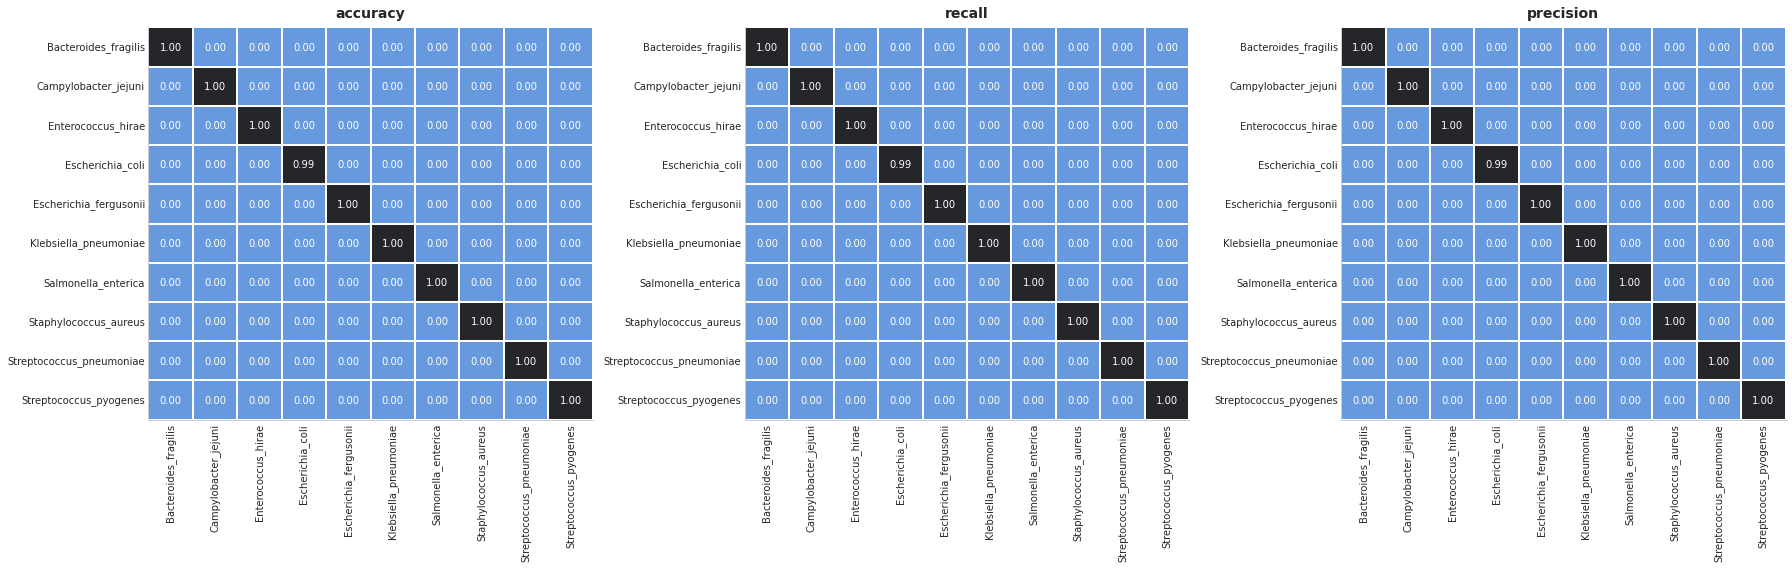

In [33]:
# create confusion matrix, calculate accuracy,recall & precision
cm = pd.DataFrame(data = confusion_matrix(y, oof_y_hat, labels = le.classes_), index = le.classes_, columns = le.classes_)
plot_cm(cm)

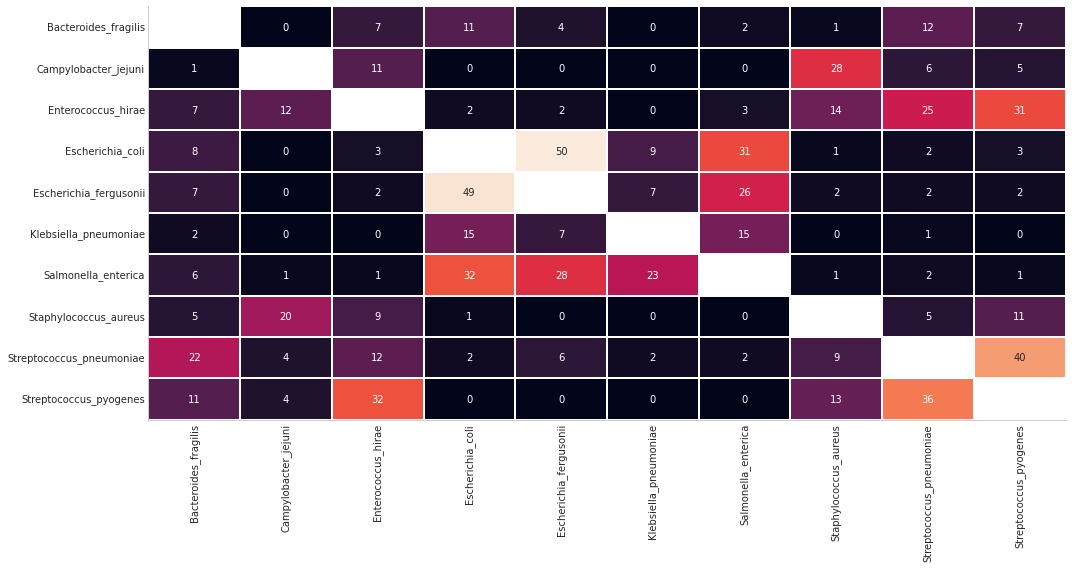

In [34]:
def plot_cm_error(cm):
    mask = (np.eye(cm.shape[0]) != 0) * 1
    fig, ax = plt.subplots(tight_layout=True, figsize=(15,8))
    sns.heatmap(
                data = pd.DataFrame(data=cm, index=le.classes_, columns = le.classes_),
#                 cmap=sns.dark_palette("#69d", reverse=True, as_cmap=True),
                cbar = False,
                lw = 0.25,
                mask = mask,
                annot = True,
                fmt = '.0f',
                ax = ax
            )
    sns.despine()
    
plot_cm_error(confusion_matrix(y, oof_y_hat, labels = le.classes_))

In [35]:
preds_test.shape

(100000, 10)

In [36]:
pred_hat = preds_test.argmax(axis=1)
pred_hat0 = le.inverse_transform(pred_hat)

# Submission

In [37]:
sub = pd.read_csv(INPUT + '/sample_submission.csv')
sub[column_y] = pred_hat0
sub.to_csv("submission.csv", index=False)
sub.to_csv("submission_00.csv", index=False)
display(sub.head(10))
display(sub.tail(10))

,row_id,target
0,200000,Escherichia_fergusonii
1,200001,Salmonella_enterica
2,200002,Enterococcus_hirae
3,200003,Salmonella_enterica
4,200004,Staphylococcus_aureus
5,200005,Escherichia_fergusonii
6,200006,Salmonella_enterica
7,200007,Staphylococcus_aureus
8,200008,Streptococcus_pneumoniae
9,200009,Klebsiella_pneumoniae


,row_id,target
99990,299990,Escherichia_fergusonii
99991,299991,Klebsiella_pneumoniae
99992,299992,Streptococcus_pneumoniae
99993,299993,Klebsiella_pneumoniae
99994,299994,Escherichia_coli
99995,299995,Streptococcus_pneumoniae
99996,299996,Bacteroides_fragilis
99997,299997,Bacteroides_fragilis
99998,299998,Bacteroides_fragilis
99999,299999,Streptococcus_pyogenes


In [38]:
np.unique(sub[column_y], return_counts=True)

(array(['Bacteroides_fragilis', 'Campylobacter_jejuni',
        'Enterococcus_hirae', 'Escherichia_coli', 'Escherichia_fergusonii',
        'Klebsiella_pneumoniae', 'Salmonella_enterica',
        'Staphylococcus_aureus', 'Streptococcus_pneumoniae',
        'Streptococcus_pyogenes'], dtype=object),
 array([ 9954, 10196,  9464,  8615, 10741,  9848, 10539,  9890, 10511,
        10242]))

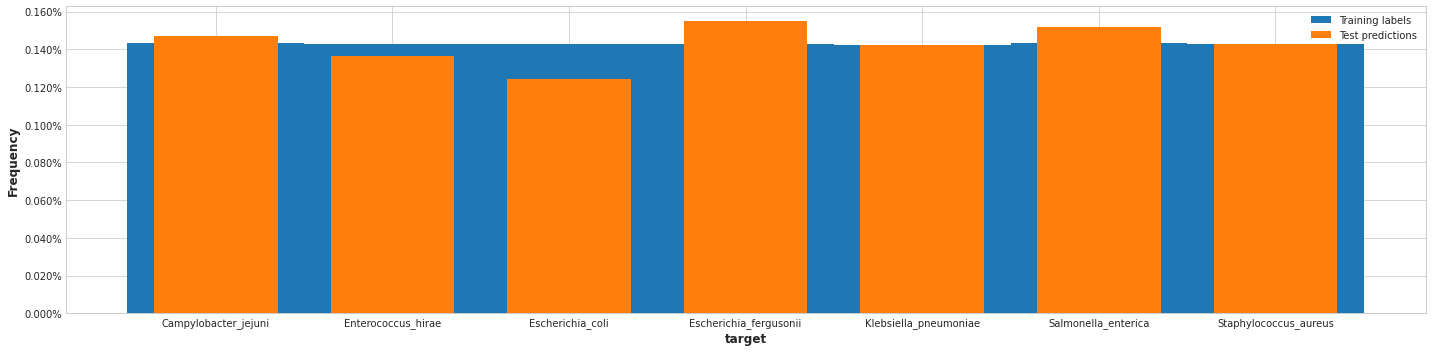

In [39]:
# Plot the distribution of the test predictions vs training set
plt.figure(figsize=(20,5))
plt.hist(y[column_y], bins = np.linspace(0.5, 7.5, 8), density = True, label = 'Training labels')
plt.hist(sub[column_y], bins = np.linspace(0.5, 7.5, 8), density = True, rwidth = 0.7, label = 'Test predictions')
plt.xlabel(column_y)
plt.ylabel('Frequency')
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.legend()
plt.show()

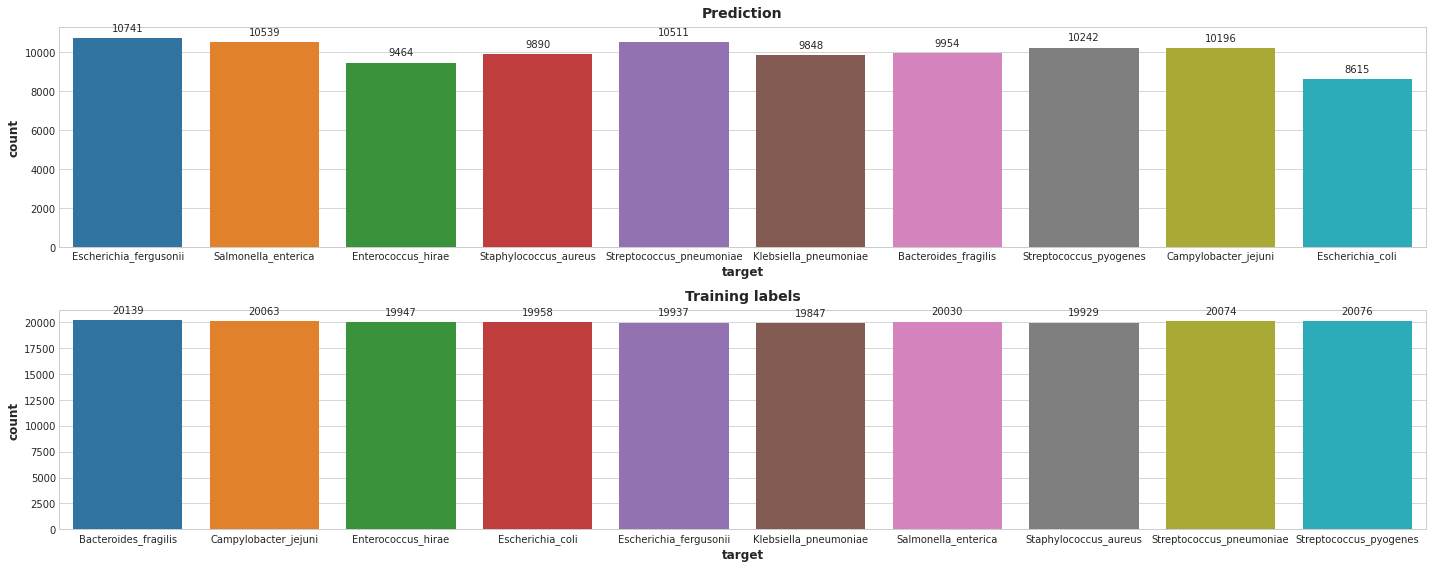

In [40]:
def plot_x_labels(ax):
    for rect in ax.patches:
        height = rect.get_height()
        ax.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                    xytext=(0, 5), textcoords='offset points', ha='center', va='bottom') 

# Plot the distribution of the test predictions
fig, ax = plt.subplots(2,1,figsize = (20,8))
sns.countplot(x = sub[column_y], ax = ax[0], orient = "h").set_title("Prediction")
plot_x_labels(ax[0])
# Plot the distribution of the training set
sns.countplot(x = y[column_y], ax = ax[1], orient = "h").set_title("Training labels")
plot_x_labels(ax[1])
fig.show()

To submit these predictions to the competition, follow these steps:

1. Begin by clicking on the blue **Save Version** button in the top right corner of the window.  This will generate a pop-up window.
2. Ensure that the **Save and Run All** option is selected, and then click on the blue **Save** button.
3. This generates a window in the bottom left corner of the notebook.  After it has finished running, click on the number to the right of the **Save Version** button.  This pulls up a list of versions on the right of the screen.  Click on the ellipsis **(...)** to the right of the most recent version, and select **Open in Viewer**.  This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the **Output** tab on the right of the screen.  Then, click on the file you would like to submit, and click on the blue **Submit** button to submit your results to the leaderboard.

You have now successfully submitted to the competition!

# Next Steps #

If you want to keep working to improve your performance, select the blue **Edit** button in the top right of the screen. Then you can change your code and repeat the process. There's a lot of room to improve, and you will climb up the leaderboard as you work.

Be sure to check out [other users' notebooks](https://www.kaggle.com/c/tabular-playground-series-feb-2022/code) in this competition. You'll find lots of great ideas for new features and as well as other ways to discover more things about the dataset or make better predictions. There's also the [discussion forum](https://www.kaggle.com/c/tabular-playground-series-feb-2022/discussion), where you can share ideas with other Kagglers.

Have fun Kaggling!